#**Attension is all you need: A Code Walkthrough**

Author - [Meghanshu](https://github.com/Dark-Awesome/Profile) \\
Sources - [Orignal Paper - Attension is all you need](https://arxiv.org/abs/1706.03762)  
Resources - [Video by Andrej Karpathy](https://www.youtube.com/watch?v=kCc8FmEb1nY)

ChatGPT and Gemini also used for making this notebook.


####Softmax Function
Softmax normalizes an input vector into a probability distribution using the exponential function.

$Softmax = \sigma(x_k) = \exp(x_k)/ \sum_{i = 0}^n {\exp(x_i)}$

where:
* x is a vector (row / column )

In [3]:
import numpy as np

x = np.array([3,4,5])
x

array([3, 4, 5])

In [3]:
exp = np.exp(x)
softmax = exp/(np.sum(exp))
softmax

array([0.09003057, 0.24472847, 0.66524096])

In [5]:
print(softmax.sum() == 1) #Addition rule for probability

True


In [6]:
#but while implimentation we don't use this formulation, because
x = np.array([50, 1000, 5000])
exp = np.exp(x)
softmax = exp/(np.sum(exp))
softmax

<ipython-input-6-aa62c281c88c>:3: RuntimeWarning: overflow encountered in exp
  exp = np.exp(x)
<ipython-input-6-aa62c281c88c>:4: RuntimeWarning: invalid value encountered in divide
  softmax = exp/(np.sum(exp))


array([ 0., nan, nan])

As you can see `RuntimeWarning: overflow` because e^1000 is a huge number to compute. So how we can compute this?

We can actually use the cummulative property:
\begin{align}
 𝜎(x_k) = \frac{exp(x_k)}{ ∑_{i=0}^n exp(x_i) } = \frac{c \cdot exp(x_k)}{ c \cdot ∑_{i=0}^n exp(x_i) }
\end{align}

where
c can be any constant. but we usaully take $c = \text{max{x}}$

In [4]:
#here the code for production level:

def softmax(x: np.array) -> np.array:
  exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
  return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

softmax(x) # no overflow error

array([0.09003057, 0.24472847, 0.66524096])

In [14]:
x = [i for i in range(11)]
np.array(x)
exp_x = np.max(x, axis = -1) #keepdims=False #here
exp_x

np.int64(10)

In [17]:
x = [i for i in range(11)]
np.array(x)
exp_x = np.max(x, axis = -1, keepdims=True)
exp_x

array([10])

What is the difference?
when `keepdims=False` the output is just a number that as np.int64 dtype, but when `keepdims=True` it's a array of 1-Dimension.

In [26]:
x = [[j for j in range(3)] for i in range(3)]
x

[[0, 1, 2], [0, 1, 2], [0, 1, 2]]

In [28]:
array = np.array(x)
array

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [33]:
array.dtype #this is an attribute, it's like it's property.

dtype('int64')

In [35]:
type(array) #what type of object is this in class

numpy.ndarray

In [37]:
np.sum(array, axis = 0) #column-wise

array([0, 3, 6])

In [38]:
np.sum(array, axis = 1) #row-wise

array([3, 3, 3])

In [39]:
np.sum(array, axis = -1) #row-wise

array([3, 3, 3])

####Attension
Attention means "look at the important thing". It tells the model how important is a particular word or a segment of image for our task like:

* When translating: Which source word matters most?
* When summarizing: Which sentence part is important?
* When answering questions: Which words in the passage should we look at?

Mathematically, each word or token (ultimatelly a number) is converted into the main parts, which are 🧘:

* Query (Q)
* Key (K)
* Value (V)

Now let's understand each,
* A Query vector (Q) — what the word is asking about. "What am I looking for?"
* A Key vector (K) — what this word represents."What do I have?"
* A Value vector (V) — the actual content to give if it's relevant. "What info can I give?"

Our main task now becomes to map the query to the key.(similarity = attention score). Use those scores to weigh the Values and decide how much of each word's info to take.

Now we do this by first genrating Q,K,V as:

$Q_i = x_i \cdot W_i^Q $ ; $V_i = x_i \cdot W_i^V$ ; $K_i = x_i \cdot W_i^K$

where $x_i$ is the vector from input. These weight matrices are what we learn while training, this is what transfomer learns. So intially randamize weight matrices is genrated.

In [4]:
# toy input (3 tokens, 4D embeddings)
X = np.random.rand(3, #number of tokens
                   4  #dimension of each token
                   )

X

array([[0.97902532, 0.35005392, 0.4926284 , 0.75836905],
       [0.7546915 , 0.36038436, 0.66384801, 0.49889283],
       [0.13538322, 0.58249974, 0.11700363, 0.71294583]])

Each token have 4 dimension. You can read about it more on the link - [Click here](https://medium.com/@saschametzger/what-are-tokens-vectors-and-embeddings-how-do-you-create-them-e2a3e698e037)

In [6]:
# weights (4D input -> 4D query/key/value)
W_q = np.random.rand(4, 4)
W_k = np.random.rand(4, 4)
W_v = np.random.rand(4, 4)

W_q , W_k, W_v

(array([[0.76688363, 0.4790913 , 0.86008755, 0.13197275],
        [0.47894096, 0.44573239, 0.7135812 , 0.33106025],
        [0.3124558 , 0.96221384, 0.57048211, 0.71253867],
        [0.60654982, 0.74353972, 0.33653872, 0.06877175]]),
 array([[0.45623267, 0.55861005, 0.91264798, 0.45712156],
        [0.58947676, 0.76123239, 0.59147532, 0.43470804],
        [0.40876299, 0.74925683, 0.93698294, 0.62500527],
        [0.06390756, 0.58863509, 0.16541394, 0.71501189]]),
 array([[0.46237554, 0.31837436, 0.41783909, 0.8830841 ],
        [0.80001658, 0.7983166 , 0.92958101, 0.59690632],
        [0.65393169, 0.03555147, 0.01630576, 0.25187571],
        [0.55614463, 0.76213569, 0.81357702, 0.04117336]]))

In [8]:
Q = X @ W_q  # (3, 4)
K = X @ W_k  # (3, 4)
V = X @ W_v  # (3, 4)

Q #@ is sign for matrice multiplication.

array([[1.53236687, 1.66296427, 1.62809562, 0.64826476],
       [1.26138991, 1.5319115 , 1.45287444, 0.72623476],
       [0.8518018 , 0.96718599, 0.83878464, 0.34310955]])

Now as we genrated Q,K,V with untrained weights, we have to find attension. More technically the Scaled Dot-Product Attention. It's descried in the orignal paper with a beautiful diagram. It's mathematically described as:

\begin{align}
\text{Attension}(Q,K,V) = \text{softmax}(\frac{Q ⋅ K^T}{\sqrt{d_k}})V
\end{align}

where $d_k$ is dimension (`K.shape[1] or K.shape[-1]`) of $K$ i.e. Key[.](https://www.youtube.com/watch?v=nfs8NYg7yQM)

In [11]:
K.shape

(3, 4)

In [18]:
type(K.shape[-1]) #just to check 🫎

int

In [17]:
# attention scores
scores = Q @ K.T        # (3, 3)
scaled = scores / np.sqrt(K.shape[-1]) #last dimension.
weights = softmax(scaled)

output = weights @ V    # (3, 4)

One important thing before we move ahead. The dimension of each token is the dimension of our model which is equal to the dimension of word embedding as seen before.

$x_i ϵ \mathbb{R}^{d_{model}} $

The trickyy part comes now, how do we decide the dimesion of key, value and query ? Now if your not following up here is the context,

$Q_i = x_i \cdot W_i^Q $ ; $V_i = x_i \cdot W_i^V$ ; $K_i = x_i \cdot W_i^K$ so we used this to calculate the Q,K,V and mat-multiply Weights ($W_i^{Q,K,V}$). Now the dimension of weights are $\mathbb{R}^{d_{model} × d_k}$. The $d_{model}$ is decided by the word embedding dimension, again coming back from where we started, how do we decide $d_{q,k,v}$?

so in multi-head attension we split the input into "head", which we gonna see in the next section. (Recommend to visit this note again after reading that) so
\begin{align}
d_{k,v,q} = \frac{d_{model}}{h}
\end{align}

where $h$ is the number of head.

This is the thumb rule and mostly you gonna need that in practice. 🧘

In [23]:
def self_attention(X, W_Q, W_K, W_V):
    Q = X @ W_Q
    K = X @ W_K
    V = X @ W_V

    d_k = Q.shape[-1]
    scores = (Q @ K.T) / np.sqrt(d_k)
    weights = softmax(scores)
    output = weights @ V

'''The Clean Code for Self-Attension.'''

'The Clean Code for Self-Attension.'

####Multi-head Attention
Instead of learning one set of Q, K, V, we learn multiple sets in parallel (called "heads"). Each head captures different types of relationships.
We then concatenate all heads and apply a final linear projection. Each "head" can focus on different relationships between words.

Now the question is what does the different projection of input mean?
It's like the mathematical transformation, just as we have the input vector $x_i$ and we wanted $Q,K,V$ from it.

How do we divide input for feeding into each head. Take an example where the $h$ (number of head) is 8, usually $d_{model} = 512$, so $d_k = \frac{d_{model}}{h} = 64$ ; for each head we have different set of $W_i^{Q,K,V}$ $ϵ$ $\mathbb{R^{512 \times 64}}$. We have 8 (equal to number of head) diff weight matrices ($Q,K,V$).
After dividing we concatinate them all as

$MultiHeadOutput = Concat(head_1,head_2,...,head_h) \cdot W^o$

where $W^o$ $ε$ $\mathbb{R^{(h \cdot d_v) \times d_{model}}}$


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, T, C = x.size()
        H = self.num_heads
        D = self.head_dim #per head dimension

        Q = self.W_q(x).view(B, T, H, D).transpose(1, 2)
        K = self.W_k(x).view(B, T, H, D).transpose(1, 2)
        V = self.W_v(x).view(B, T, H, D).transpose(1, 2)

        scores = Q @ K.transpose(-2, -1) / (D ** 0.5)
        weights = F.softmax(scores, dim=-1)

        out = weights @ V
        out = out.transpose(1, 2).contiguous().view(B, T, C)

        return self.W_o(out)

'''
Q.view(2, 5, 2, 4) → [2, 5, 2, 4]

Q.transpose(1, 2)  → [2, 2, 5, 4] ✅
'''

In PyTorch, `.transpose(dim0, dim1)` swaps two dimensions of a tensor — it doesn't shuffle data values, just changes how they're indexed.

#### Transformer with positional encoding

In [19]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

Why needing postional encoding? unlike RNNs, transformers take every input simutaniouly/parallely so we need something to take care of the postion.

You may ask why sin/cos functions ??

<ol type = "i" >
<li>Smooth and continuous → easy for models to learn from
<li>Unique for every position → no two positions have the same encoding
<li>Capturing both local and global patterns using different frequencies
<li>Extrapolatable to longer sequences (generalize beyond training)
<li>Parameter-free → no learning required, just computed
</ol>

We might have used the Learnable Positional Embeddings that what GPT-2.0 and BERT use. or fixed sin encoding scheme.

Bonus -
<ul>
<li>Rotary Positional Embedding (RoPE) — used in LLaMA and GPT-NeoX
<li>ALiBi — encodes position as a linear bias in attention scores
<li>Relative positional embeddings — used in Transformer-XL, T5
</ul>


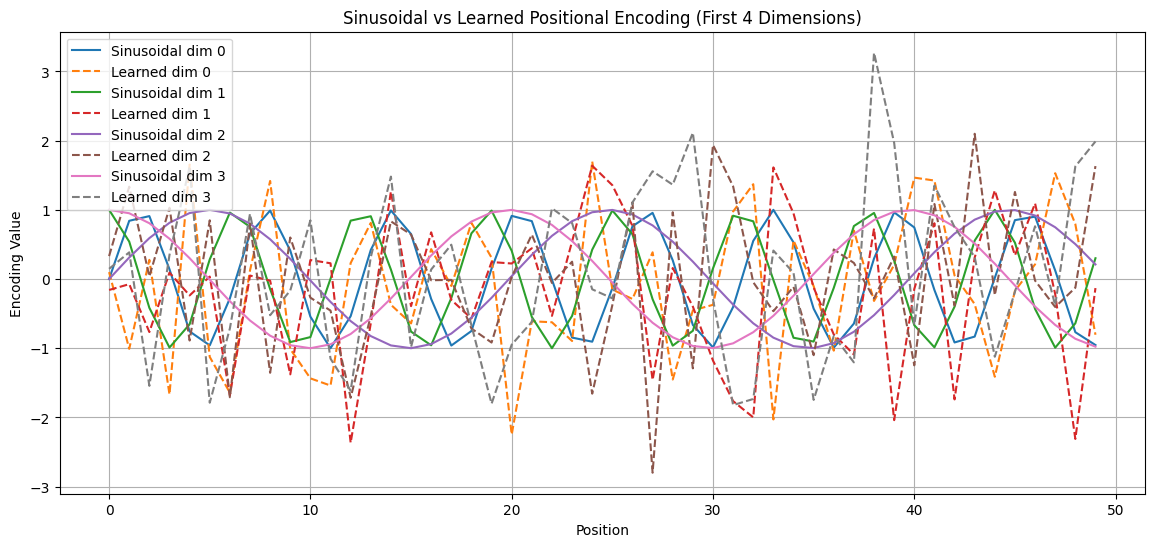

In [3]:
import torch
import math
import matplotlib.pyplot as plt

# Sinusoidal Positional Encoding
def get_sinusoidal_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# Learned Positional Encoding
def get_learned_encoding(seq_len, d_model):
    return torch.randn(seq_len, d_model)

seq_len = 50
d_model = 16

sin_pe = get_sinusoidal_encoding(seq_len, d_model)
learned_pe = get_learned_encoding(seq_len, d_model)

plt.figure(figsize=(14, 6))
for i in range(4):
    plt.plot(sin_pe[:, i], label=f"Sinusoidal dim {i}", linestyle='-')
    plt.plot(learned_pe[:, i], label=f"Learned dim {i}", linestyle='--')
plt.title("Sinusoidal vs Learned Positional Encoding (First 4 Dimensions)")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.grid(True)
plt.legend()
plt.show()

### 🔍 Understanding Frequency in Sinusoidal Positional Encoding

We might ask:

> “Aren’t we just plugging in numbers into sin/cos for position and dimension?  
> Where is the ‘frequency’ actually coming in?”

Let’s break it down clearly.

---

### 🧠 Formula

For a given position `pos` and model dimension index `i`, we use:

\begin{align}
\text{PE}_{(pos, 2i)} = \sin\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right)
\quad \text{and} \quad
\text{PE}_{(pos, 2i+1)} = \cos\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right)
\end{align}

Here, `d_model` is the dimension of the model (like 512 or 768).

---

### 📈 Where is Frequency?

Each dimension has a different **scaling factor** (frequency):


\begin{align}
\omega_i = \frac{1}{10000^{2i/d_{\text{model}}}}
\end{align}
So as you change `pos`, the encoding becomes:


\begin{align}
\text{PE}(pos, i) = \sin(\omega_i \cdot \text{pos}) \quad \text{or} \quad \cos(\omega_i \cdot \text{pos})
\end{align}

✅ This is literally a **sine or cosine wave** with frequency `ω_i`.

---

### 🧠 Type of Frequency?

- This is not time frequency like sound.
- This is **spatial frequency** — how quickly the encoding values change with position.

| Dimension | Frequency (ω) | Pattern |
|----------|----------------|---------|
| Small `i` | High frequency | Fast oscillations |
| Large `i` | Low frequency  | Slow oscillations |

---

### 🎼 Analogy: Like a Music Chord

Each position gets a vector composed of sinusoids with multiple frequencies.

- High frequency → fine local patterns
- Low frequency → long-range context

The model uses these as a **positional fingerprint**.

---

### ✅ Why This Works

- Each position has a **unique pattern**.
- Attention layers can **compare phase differences** to infer **relative distance**.
- It behaves like a **Fourier basis**, capturing both local and global structures.

---



In [7]:
def attention(Q, K, V, mask=None):
    scores = Q @ K.transpose(-2, -1) / math.sqrt(Q.size(-1))  # [B, H, T, T]
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    weights = torch.softmax(scores, dim=-1)
    return weights @ V

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_head = d_model // num_heads
        self.num_heads = num_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        qkv = self.qkv(x)  # [B, T, 3*D]
        qkv = qkv.view(B, T, 3, self.num_heads, self.d_head).transpose(1, 3)  # [B, H, T, 3*D_head]
        Q, K, V = qkv.unbind(dim=2)  # each is [B, H, T, D_head]
        out = attention(Q, K, V)
        out = out.transpose(1, 2).contiguous().view(B, T, D)  # merge heads
        return self.o_proj(out)

In [10]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x


In [12]:
class MiniTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=4, num_layers=2, d_ff=512, max_len=512):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.blocks = nn.Sequential(*[
            TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.token_emb(x)
        x = self.pos_enc(x)
        x = self.blocks(x)
        return self.lm_head(x)


In [14]:
import torch
import random
from torch.utils.data import Dataset, DataLoader

vocab_size = 10  # fake vocab of tokens 0 to 9
seq_len = 8
batch_size = 4

# Generate random sequences
class ToyDataset(Dataset):
    def __init__(self, num_samples=1000):
        self.data = []
        for _ in range(num_samples):
            seq = torch.randint(0, vocab_size, (seq_len + 1,))
            self.data.append(seq)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][:-1]  # input
        y = self.data[idx][1:]   # target (next token)
        return x, y

dataset = ToyDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MiniTransformer(vocab_size=vocab_size, d_model=64, num_heads=4, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [16]:
for epoch in range(20):
    model.train()
    total_loss = 0

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)  # [B, T, vocab]
        loss = criterion(logits.view(-1, vocab_size), yb.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

Epoch 1, Loss: 1.3879
Epoch 2, Loss: 0.3409
Epoch 3, Loss: 0.3075
Epoch 4, Loss: 0.3441
Epoch 5, Loss: 0.3004
Epoch 6, Loss: 0.2881
Epoch 7, Loss: 0.2855
Epoch 8, Loss: 0.3110
Epoch 9, Loss: 0.2833
Epoch 10, Loss: 0.2780
Epoch 11, Loss: 0.2802
Epoch 12, Loss: 0.2982
Epoch 13, Loss: 0.2770
Epoch 14, Loss: 0.2804
Epoch 15, Loss: 0.2623
Epoch 16, Loss: 0.2535
Epoch 17, Loss: 0.2464
Epoch 18, Loss: 0.2408
Epoch 19, Loss: 0.2969
Epoch 20, Loss: 0.2467


In [17]:
def generate(model, start, max_len=20):
    model.eval()
    generated = start.clone().detach().to(device)

    for _ in range(max_len):
        logits = model(generated[:, -seq_len:])  # crop to max input length
        next_token_logits = logits[:, -1, :]  # last timestep
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)

    return generated

In [18]:
start = torch.randint(0, vocab_size, (1, 1))  # batch=1, start with 1 token
generated = generate(model, start)
print("Generated sequence:", generated.squeeze().tolist())

Generated sequence: [1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 9, 1, 1, 1, 9, 2, 1, 3, 5]
